In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

C:\Users\vaski\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train = pd.read_csv('products_sentiment_train.tsv', sep='\t', header=None)
train.columns=['text','target']

In [3]:
train

,text,target
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1
...,...,...
1995,"speaker phone quality is good , and poping in ...",1
1996,"the "" movies "" last about 5 seconds .",0
1997,overall i like it .,1
1998,i began taking pics as soon as i got this came...,1


In [4]:
test = pd.read_csv('products_sentiment_test.tsv', sep='\t', header=0)

In [5]:
train_sentences = train['text'].values

train_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in train_sentences]
labels = [train['target'].loc[i] for i in train.index]

In [6]:
print(train_sentences[1000])

[CLS] if you 've been listening to cd 's in your car for awhile , dealing with the drop-off in sound quality may take some getting used to . [SEP]


In [7]:
# train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

['[CLS]', '2', '.', 'take', 'around', '10', ',', '000', '640', '##x', '##48', '##0', 'pictures', '.', '[SEP]']


In [9]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [10]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [11]:
len(validation_masks)

200

In [12]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [13]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [14]:
train_labels

tensor([1, 1, 1,  ..., 0, 1, 1])

In [15]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=16
)

In [16]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=16
)

In [17]:
from pytorch_transformers import AdamW, BertForSequenceClassification

In [18]:
# model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
# model.to('cpu')

In [19]:
import joblib
# joblib.dump(model, 'bert_classif_cased')

In [27]:
model = joblib.load('bert_classif')

In [28]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [29]:
device = 'cpu'
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x)) - 0.000001
    return e_x

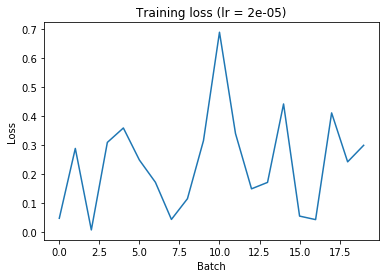

KeyboardInterrupt: 

In [23]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени

valid_history = []
train_loss = 0
best_valid_loss = float('inf')

# Обучение
# Переводим модель в training mode
for i in [1e-4,1e-5,2e-5,3e-5,5e-5]:
    train_loss_set = []
    optimizer = AdamW(optimizer_grouped_parameters, lr=i)
    print(f'\n__________________\nLR = {i}\n')
    model.train()

    for step, batch in enumerate(train_dataloader):
        # добавляем батч для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)
        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # если не сделать .zero_grad(), градиенты будут накапливаться
        optimizer.zero_grad()

        # Forward pass
        loss = model(b_input_ids.to(torch.long), token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        train_loss_set.append(loss[0].item())  

        # Backward pass
        loss[0].backward()

        # Обновляем параметры и делаем шаг используя посчитанные градиенты
        optimizer.step()

        # Обновляем loss
        train_loss += loss[0].item()

        # Рисуем график
        clear_output(True)
        plt.plot(train_loss_set)
        plt.title(f"Training loss (lr = {i})")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()
    print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))
    # Валидация
    # Переводим модель в evaluation mode
    model.eval()

    valid_preds, valid_labels = [], []

    for batch in validation_dataloader:   
        # добавляем батч для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)

        # Распаковываем данные из dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # При использовании .no_grad() модель не будет считать и хранить градиенты.
        # Это ускорит процесс предсказания меток для валидационных данных.
        with torch.no_grad():
            logits = model(b_input_ids.to(torch.long), token_type_ids=None, attention_mask=b_input_mask)

        # Перемещаем logits и метки классов на CPU для дальнейшей работы
        logits = logits[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        batch_preds = logits[:,1]
        batch_labels = label_ids     
        valid_preds.extend(batch_preds)
        valid_labels.extend(batch_labels)

    valid_loss = log_loss(valid_labels, softmax(valid_preds))
    print("Log Loss на валидационной выборке: {0:.2f}".format(
         valid_loss
    ))
    valid_history.append(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

In [24]:
valid_history

[0.2935009400034352, 0.5452647040982294]

In [30]:
model.load_state_dict(torch.load('model.pt'))

In [31]:
pr = (softmax(valid_preds)-0.0000001)
log_loss(np.array(valid_labels), np.array(pr))

0.5452650550263968

In [32]:
np.max(pr)

0.99999887

In [33]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test.text]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

In [34]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
# prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks#,
#     prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=16
)

In [35]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids.to(torch.long), token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = logits[:,1]
    test_preds.extend(batch_preds)

In [36]:
preds = softmax(test_preds)

In [37]:
np.min(preds), np.max(preds), np.sum(preds), len(preds)

(0.040798686, 0.999999, 359.48672, 500)

In [38]:
test[['Id']].merge(pd.DataFrame(preds,columns=['y']), on=np.arange(len(test)))[['Id','y']].\
            to_csv('subm_bert_2.csv', index=False)